In [1]:
%matplotlib inline


Translation with a Sequence to Sequence Network and Attention
*************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <https://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

And for more, read the papers that introduced these topics:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__


**Requirements**



In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [3]:
SOS_token = 0
EOS_token = 1

#添加token，將data的字添加編號(字典形式)，計算每個字出現的次數，紀錄總字數。
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS   #紀錄的總字數
    
    #將句子傳入(這邊會傳入lang)，以' '切開成list，依序傳入addWord
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    
    def addWord(self, word):
        #傳入的word判斷是否已經編好索引，如果還沒則..
        if word not in self.word2index:
            #n_words表示目前字數，因為索引從0開始，所以也代表要新增的索引目前指標位置。
            #編入 index-word，key=word，value=目前索引總數(n_words)，所以第一個為0
            self.word2index[word] = self.n_words
            #編入計數器，key=word，value=1
            self.word2count[word] = 1
            #編入 word-index，key=目前索引總數(n_words)，value=word
            self.index2word[self.n_words] = word
            #都完成了之後，n_words+1
            self.n_words += 1
        else:
            #如果已經編過索引，則計數器+1
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
#Unicode轉成ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

#去掉標點符號跟特殊自符
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [5]:
#reverse = 將翻譯data的語言順序反轉
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    #讀取eng-fra 英語翻法語，格式為(eng-seq)\t(fra)\n，去掉頭尾空字符跟換行符
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    #每row以\t分隔成list，去掉標點符號跟特殊自符，格式為Pairs=[[line1],[line2]...]，Pair=line1=[Lang1,Lang2]
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    #每row的列表反轉。
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        #建立Lang，名稱為傳入的lang2(str)、lang1(str)
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    # 傳回建立好的類，以及pairs
    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [6]:
MAX_LENGTH = 10

#前綴
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

#Pairs=[[line1],[line2]...]，Pair=line1=[Lang1,Lang2]，將piar傳入。
#將Lang1、Lang2以' '分隔的列表的長度如果小於MAX_LENGTH，且Lang2開頭是以eng_prefixes開頭則傳回True。
#因為這個教程是以法語翻英語，前綴是英語，所以取英文的Lang2傳入startswith。
#資料格式是eng-fra，但會先經過readLangs(reverse=True)
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

#將pairs取出pair
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [7]:
#準備Data，
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    #打印共取了幾對翻譯
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    #打印過濾後剩幾對翻譯
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        #pair[0]=lang1,pair[1]=lang2，個別傳入建立好的語言類
        #個別將法語跟英語紀錄word數跟編好index-word、word-index的字典方便查表
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    #個別打印字數
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    #將包裝著查表的類以及Pairs=[[line1],[line2]...]傳回
    return input_lang, output_lang, pairs

#input_lang = fra，output_lang = eng
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
#隨機打印其中一對翻譯
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis une inconditionnelle de l opera allemand .', 'i m a fan of german opera .']


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [8]:
#建立模型
class EncoderRNN(nn.Module):
    #初始化，傳入輸入維度跟隱藏層維度，這邊是法翻英，所以會輸入fra的lang類的單詞數(4345)
    #input是字index，格式為(seq_len,batch_size,one-hot_word_index)
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        #Embedding降維，建立一個查表，一個索引對向量的tensor矩陣(input_size, hidden_size) 
        #這邊都不作詞義分析而是直接隨機做空間上的轉換，而這邊剛好為降維後維度hidden_size。
        self.embedding = nn.Embedding(input_size, hidden_size)   
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        #這邊input的seq_len=1、batch_size=1，輸入input輸出為(input_shape,hidden_size)
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    #設置ht，位存值初始為h0=torch.zeros(1, 1, self.hidden_size)，格式為(GRU_layer_num,batch_size,hidden_size)。
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





架構
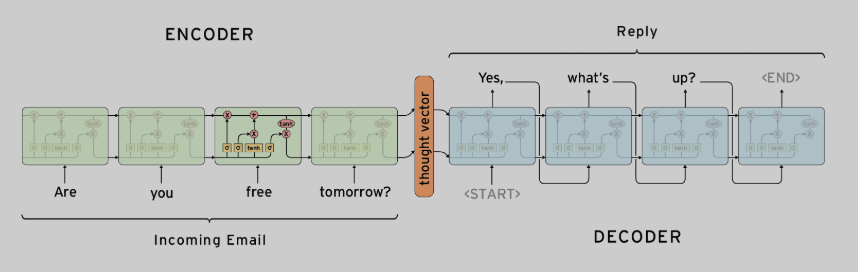

In [9]:
class DecoderRNN(nn.Module):
    #output_size為所有法語的字數
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        #Embedding降維，建立一個查表，一個索引對向量的tensor矩陣(output_size, hidden_size) 
        #這邊都不作詞義分析而是直接隨機做空間上的轉換，而這邊剛好為降維後維度hidden_size。
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    #hidden(h0)會是EncoderRNN最後一個seq的output=ht
    #因為只有一層GRU，所以output只有最後一層，RNN最後一層的output為ht。
    #第一個input為token==>SOS這個word的index，Tensor([[0]])，input.shape=(1,1) 
    #第一個hidden=encoder_outputs為encoder_outputs輸出的ht(上下文向量)
    def forward(self, input, hidden):
        #input.shape=(1,1) 
        #輸入input輸出為(input_shape,hidden_size)，而我們設定seq_len=1、batch_size=1，所以轉成(1,1,hidden_size)
        output = self.embedding(input).view(1, 1, -1)
        #relu減少一些輸入而作用不大的神經元
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        #輸出為有法語的字數的one-hot-encode的機率
        output = self.softmax(self.out(output[0]))
        return output, hidden
    #設置ht，位存值初始為h0=torch.zeros(1, 1, self.hidden_size)，格式為(GRU_layer_num,batch_size,hidden_size)。
    def initHidden(self):
        #設置ht，位存值初始為h0=torch.zeros(1, 1, self.hidden_size)，格式為(GRU_layer_num,batch_size,hidden_size)。
        #在這個教程的架構，解碼的hidden輸入為EncoderRNN，所以用不到。
        #若input用EncoderRNN的ht就可能會初始化另一個DecoderRNN的h0。
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [10]:
class AttnDecoderRNN(nn.Module):
    #output_size為所有法語的字數
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        #輸出語言英語儲存的字總數
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        #Embedding降維，建立一個查表，一個索引對向量的tensor矩陣(output_size, hidden_size) 
        #這邊都不作詞義分析而是直接隨機做空間上的轉換，而這邊剛好為降維後維度hidden_size。
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        #注意力轉換神經元
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    #hidden(h0)會是EncoderRNN最後一個seq的output=ht
    #因為只有一層GRU，所以output只有最後一層，RNN最後一層的output為ht。
    #第一個input為token==>SOS這個word的index，Tensor([[0]])，input.shape=(1,1) 
    #第一個hidden=h0 (value=zeros) ，之後的hidden為上一個序列的ht，(GRU_layer_num,batch_size,hidden_size)
    #encoder_outputs為encoder_output輸出的ht
    #encoder_outputs = (max_length, encoder.hidden_size)
    def forward(self, input, hidden, encoder_outputs):
        #input.shape=(1,1) ，input=(index,1)
        #輸入input輸出為(input_shape,hidden_size)，而我們設定seq_len=1、batch_size=1，所以轉成(1,1,hidden_size)
        embedded = self.embedding(input).view(1, 1, -1)
        #dropout層，將輸入的word進行dropout
        embedded = self.dropout(embedded)
        #將input、hidden合併起來，然後經過轉換成一組長度為max_length的機率(總和為1)
        #embedded[0].shape=(1,hidden_size)，hidden[0]=(1,hidden)
        #torch.cat((embedded[0], hidden[0]), 1))的shape=(1,hidden*2)
        #attn_weights_shape = (1,10)
        #更新attn權重表示從輸入的input的word的訊息以及前序列預測的hidden訊息中，
        #學習怎麼從這兩個訊息中去取encoder_outputs的訊息。
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        #attn_weights.unsqueeze(0)=(1,1,10)
        #encoder_outputs = (10, encoder.hidden_size)
        #encoder_outputs.unsqueeze(0) = (1,10,encoder.hidden_size)
        #bmm將第1個維度視為batch，將2、3維度視為矩陣，然後將矩陣dot。
        #attn_applied = (1,1,encoder.hidden_size)
        #意義為從10組編碼器的輸出中，依attn_weights所分配的比重取encoder_outputs，然後疊加到一組encoder.hidden_size中。
        #attn_applied也就是經過注意力選擇機制從encoder_outputs讀出來的資料
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        #embedded[0].shape=(1,hidden_size)、attn_applied[0] = (1,encoder.hidden_size)
        #output = (1,hidden_size+encoder.hidden_size) = (1,hidden_size*2)
        #輸入的word與注意力從encoder_outputs讀出來的資料串接
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        #再從這兩個輸入學習怎麼從hidden_size*2中取資料降到hidden_size一個字的維度(1,hidden_size*2)
        #在0維增加一個維度 =>  (1,1,hidden_size*2)
        output = self.attn_combine(output).unsqueeze(0)
        #經過relu層
        output = F.relu(output)
        #將output(input+ encoder_outputs(由input+hidden判斷取出的訊息))以及hidden作為GRU輸入
        #output_size(1,hidden_size)
        output, hidden = self.gru(output, hidden)
        #輸出output[0] (1,hidden_size)再做一次線性轉換成(1,output_size)，從向量轉回索引的one-hot形式(batch,output_size)。
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [11]:
#傳入一種語言類以及句子
#將句子以 ' '切開成列表，[word1,word2,....]
#再將每個字轉成索引index，[word1_index,word2_index.....]
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

#傳入一種語言類以及句子
def tensorFromSentence(lang, sentence):
    #[word1_index,word2_index.....]
    indexes = indexesFromSentence(lang, sentence)
    #列表最後加入EOS_token(結束標誌,index=1)
    indexes.append(EOS_token)
    #轉成tensor，形狀轉為(seq_len+1(EOS_token),1)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

#Pairs=[[line1],[line2]...]，Pair=line1=[Lang1,Lang2]
#傳入pair，pair[0] 輸入的語言句子， pair[1]輸出的語言句子
#input_lang = 之前建立的類(保存index-word互換表、總儲存字數)
#output_lang = 之前建立的類(保存index-word互換表、總儲存字數)
def tensorsFromPair(pair):    
    #input_tensor = (seq_len+1(EOS_token),1)  法語
    input_tensor = tensorFromSentence(input_lang, pair[0])
    #target_tensor = (seq_len+1(EOS_token),1)  英語
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [12]:
#多少比例使用teacher_forcing
teacher_forcing_ratio = 0.5

#訓練
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    #encoder_hidden 初始化encoder的h0
    encoder_hidden = encoder.initHidden()
    #先將encoder_optimizer、decoder_optimizer梯度清零
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    #計算input跟output句子長度(seq_len)
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    #encoder_outputs =  torch.zeros(max_length, encoder.hidden_size)，初始化encoder的ht
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    #清零loss
    loss = 0
    #循環input_length次數
    for ei in range(input_length):
        #input_tensor.shape=(seq_len+1(EOS_token),1) 
        #encoder使用encoder_hidden紀錄h0，encoder_outputs紀錄ht
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        #輸出的encoder_output，encoder_outputs
        #輸出的encoder_output格式為(GRU_layer_num,batch_size,hidden_size)
        #encoder_outputs = (max_length, encoder.hidden_size)
        #如果input_length < max_length，則其餘沒被修改到的encoder_outputs為zeros
        encoder_outputs[ei] = encoder_output[0, 0]
        
    #解碼輸入第一個input = SOS_token(index=0)，decoder_input.shape=(1,1)
    decoder_input = torch.tensor([[SOS_token]], device=device)
    #decoder_hidden直接以encoder_hidden(h0)初始化
    decoder_hidden = encoder_hidden
    #如果random.random() < teacher_forcing_ratio為True，否則False
    #random.random() 0~1隨機數
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    #如果為真
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        #循環output_length次數
        for di in range(target_length):
            #將decoder_input, decoder_hidden, encoder_outputs傳入decoder
            #encoder_outputs = (max_length, encoder.hidden_size)
            #傳回decoder_output, decoder_hidden, decoder_attention
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)  
            #decoder_output.shape = (1,output_size)，one-hot-encoder形式
            #target_tensor.shape=(seq_len+1(EOS_token),1) 取第[di]個，shape為(1,1)取出來為(index值)
            #NLLLoss輸入為((batch,class_num)) , batch(index))，pytorch的一個坑
            #計算loss加總
            loss += criterion(decoder_output, target_tensor[di])
            #將target_tensor答案作為下個序列的輸入
            decoder_input = target_tensor[di]  # Teacher forcing
            #總共會循環target_length次，例如How are you EOS 循環4次，
            #第一次輸入SOS預測HOW，第二次輸入 How 輸出 are，第三次輸入are輸出you，第四出輸入you輸出EOS

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #decoder_output.shape = (1,output_size)
            #沿著指定維度返回最大k個數值及其索引值，返回最大值，以及他的索引。
            #因為topk沒給dim參數，所以傳回最後一個維度的最大值，以及他的索引。
            #topi.shape=(1,1,1)
            topv, topi = decoder_output.topk(1)
            #將decoder_output預測作為下個序列的輸入
            #squeeze()去掉第一維，變成(1,1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            #decoder_output.shape = (1,output_size)，one-hot-encoder形式
            #target_tensor.shape=(seq_len+1(EOS_token),1) 取第[di]個，shape為(1,1)取出來為(index值)
            #NLLLoss輸入為((batch,class_num)) , batch(index))，pytorch的一個坑
            #計算loss加總
            loss += criterion(decoder_output, target_tensor[di])
            #總共會循環target_length次，例如How are you EOS 循環4次，
            #第一次輸入SOS預測HOW，第二次輸入 How 輸出 are，第三次輸入are輸出you，第四出輸入you輸出EOS
            #如果預測為EOS_token則提早退出，若都預測正確會在target_length次退出
            if decoder_input.item() == EOS_token:
                break
    #計算梯度
    loss.backward()
    #更新權重
    encoder_optimizer.step()
    decoder_optimizer.step()
    #傳回loss除以target_length，這一個句子的平均loss
    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [13]:
import time
import math

#除以60秒向下取整換算成分鐘
def asMinutes(s):
    m = math.floor(s / 60)
    #除後剩下的秒數
    s -= m * 60
    #傳回換算好的幾分幾秒
    return '%dm %ds' % (m, s)

#
def timeSince(since, percent):
    #記錄現在的時間
    now = time.time()
    #秒數為現在減去之前開始訓練時的時間，兩個的時間差
    s = now - since
    #秒數除以現在完成百分比，等於推測總共需要的秒數
    es = s / (percent)
    #rs等於設下的秒數
    rs = es - s
    #將用了幾秒以及剩幾秒換算成幾分幾秒傳回
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [14]:
#n_iters = 迭代次數
#print_every 每幾次打印進度
#plot_every 每幾次紀錄繪圖
#learning_rate 學習率
#encoder、decoder 編解碼的類
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    #記錄運算開始時間
    start = time.time()
    #建立空列表紀錄要繪圖的losses
    plot_losses = []
    #紀錄迭代次數
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    #建立優化器，雖然設置兩個optimizer但參數一樣，在train迭代次數也一樣
    #所以基本上兩個optimizer作用相同，只是一個更新encoder、一個更新decoder。
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    #Pairs=[[line1],[line2]...]，Pair=line1=[Lang1,Lang2]
    #從pairs隨機選擇一筆(一對)資料(line)，共取n_iters筆
    #tensorsFromPair傳回(input_Tensor,output_Tensor)
    #Tensor.shape=(seq_len+1(EOS_token),1) ，Tensor=[ [word_index1],[word_index2].... ]
    #training_pairs = [(input_Tensor,output_Tensor)1,(input_Tensor,output_Tensor)2.....]
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    #設置loss function
    criterion = nn.NLLLoss()
    #iter = 1~n_iters
    for iter in range(1, n_iters + 1):
        #取第一筆training_pairs
        training_pair = training_pairs[iter - 1]
        #個別取出input_tensor、target_tensor，Tensor.shape=(seq_len+1(EOS_token),1) 
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        #開始訓練 
        #傳回傳入這一個句子訓練時每個字的平均loss
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        #將loss加總
        print_loss_total += loss
        plot_loss_total += loss
        #如果迭代次數到了指定打印次數
        if iter % print_every == 0:
            #計算迭代了 print_every 句的句子平均loss
            print_loss_avg = print_loss_total / print_every
            #總紀錄loss清零重新記錄
            print_loss_total = 0
            #打印用了多少時間(幾分幾秒)、預計還要跑多少時間、目前迭代幾次、完成百分之多少、目前平均loss
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
        #如果迭代次數到了指定繪圖次數
        if iter % plot_every == 0:
            #計算迭代了 plot_every 句的句子平均loss
            plot_loss_avg = plot_loss_total / plot_every
            #存入要繪圖的列表
            plot_losses.append(plot_loss_avg)
            #總紀錄loss清零重新記錄
            plot_loss_total = 0
    #繪圖
    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [15]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [16]:
#評估
#傳入encoder、decoder、你輸入的句子、max_length
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    #禁止計算梯度
    with torch.no_grad():
        #傳入輸入語言類、你輸入的句子，將你的句子轉成index的tensor回傳
        input_tensor = tensorFromSentence(input_lang, sentence)
        #記錄長度
        input_length = input_tensor.size()[0]
        #初始化encoder的h0
        encoder_hidden = encoder.initHidden()
        #儲存輸出的encoder
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        #與train相同值行forward
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        #創建列表儲存預測的字
        decoded_words = []
        #decoder_attentions 學到的權重max_length的權重儲存，這個字學到的權重儲存
        decoder_attentions = torch.zeros(max_length, max_length)
        #不使用teacher_forcing
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #依循環字的順序存入decoder_attentions
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            #如果預測為EOS則天入列表後退出
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                #預測後添入列表
                decoded_words.append(output_lang.index2word[topi.item()])
            #下一個序列輸入為這次預測的字
            decoder_input = topi.squeeze().detach()
        #傳回decoder_attentions(0取到di)跟預測的字，取到
        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [17]:
#隨機從資料裡面抽一對句子來評估
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [18]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

4m 9s (- 58m 7s) (5000 6%) 2.8419
7m 59s (- 51m 56s) (10000 13%) 2.2782
11m 57s (- 47m 48s) (15000 20%) 1.9505
15m 50s (- 43m 35s) (20000 26%) 1.6976
19m 49s (- 39m 39s) (25000 33%) 1.5082
23m 48s (- 35m 42s) (30000 40%) 1.3536
27m 42s (- 31m 39s) (35000 46%) 1.1925
31m 38s (- 27m 41s) (40000 53%) 1.0889
35m 29s (- 23m 39s) (45000 60%) 0.9720
39m 22s (- 19m 41s) (50000 66%) 0.8726
43m 16s (- 15m 44s) (55000 73%) 0.8186
47m 8s (- 11m 47s) (60000 80%) 0.7507
51m 3s (- 7m 51s) (65000 86%) 0.6877
54m 58s (- 3m 55s) (70000 93%) 0.5922
58m 50s (- 0m 0s) (75000 100%) 0.5987


In [19]:
evaluateRandomly(encoder1, attn_decoder1)

> il se trompe completement .
= he is sadly mistaken .
< he is completely mistaken . <EOS>

> il joue avec ma chatte .
= he s playing with my cat .
< he s playing with my cat . <EOS>

> je suis paresseux .
= i am lazy .
< i m lazy . <EOS>

> nous en avons presque fini .
= we re nearly finished .
< we re nearly finished . <EOS>

> elle est coupable de vol .
= she is guilty of theft .
< she s guilty of the . <EOS>

> je ne vais pas bien du tout .
= i am not well at all .
< i m not at all all . <EOS>

> vous etes fort elegante .
= you re very sophisticated .
< you re very sophisticated . <EOS>

> je suis contre ce projet de loi .
= i m against the bill .
< i m against that of . . <EOS>

> il est membre du conseil paroissial .
= he is a member of the parish committee .
< he is a member of the world . <EOS>

> je ne fais pas partie de ses admirateurs .
= i m not a fan .
< i m not a fan . <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




In [20]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
#繪製注意力的熱度圖
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




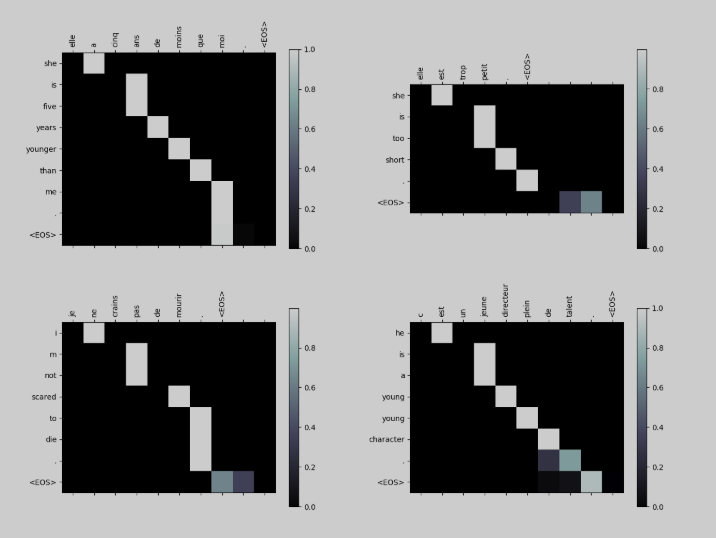

In [21]:
#添加軸和標籤的熱度圖
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

#評估以及顯示注意力熱度圖
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>
input = elle est trop petit .
output = she s too drunk . <EOS>
input = je ne crains pas de mourir .
output = i m not afraid of die . <EOS>
input = c est un jeune directeur plein de talent .
output = he s a talented young talented . <EOS>


C:\Users\Jhin\AppData\Local\conda\conda\envs\torch1\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there


